# HW 12 - Extra Credit
#### I used the code provided in the skeleton notebook at https://github.com/fedhere/PUI2016_fb55/blob/master/HW12_fb55/Assignment%201%20instructions.ipynb, as well as code from Sebasian Bana (noted below). The SQL query itself is mine.

In [34]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gp
import pandas as pd
import os
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
facilityQuery = '''SELECT count(*), zipcodes
FROM nycasthmasdismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


In [ ]:
# Zipcodes shapefile from HW 11, Assignment 2
# url = "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson"
# os.system("curl -O " + url)
# os.system("mv nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA") + "/zipcodes.geojson")

In [10]:
zipcodes = gp.read_file(os.getenv("PUIDATA") + "/zipcodes.geojson")
zipcodes = zipcodes[['geometry', 'postalCode']]

In [11]:
zipcodes['centers'] = zipcodes.centroid
zipcodes.head()

,geometry,postalCode,centers
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,POINT (-73.88357286802307 40.75166307169953)
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,POINT (-73.71160619542474 40.74537094501076)
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,POINT (-73.70344982649 40.74873122436191)
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,POINT (-73.72400273065516 40.73653495923434)
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365,POINT (-73.7946136039439 40.73990335985973)


In [25]:
zipcodes.rename(columns = {'postalCode':'zipcodes'}, inplace=True)
zipcodes['zipcodes'] = zipcodes['zipcodes'].astype(int)

In [31]:
asthma_zip_shp = facilities.merge(zipcodes, how = 'left', on = 'zipcodes')
asthma_zip_shp = asthma_zip_shp[[1, 0, 3]]
print (len(asthma_zip_shp))
asthma_zip_shp.head(5)

29


,zipcodes,count,centers
0,10461,1699,POINT (-73.84080867380536 40.84700067263105)
1,11373,405,POINT (-73.87842706401592 40.73885362850201)
2,10451,1698,POINT (-73.92373406533598 40.82077879319685)
3,11691,220,POINT (-73.76192276783287 40.60074018580426)
4,11375,246,POINT (-73.84627891822217 40.72069287356896)


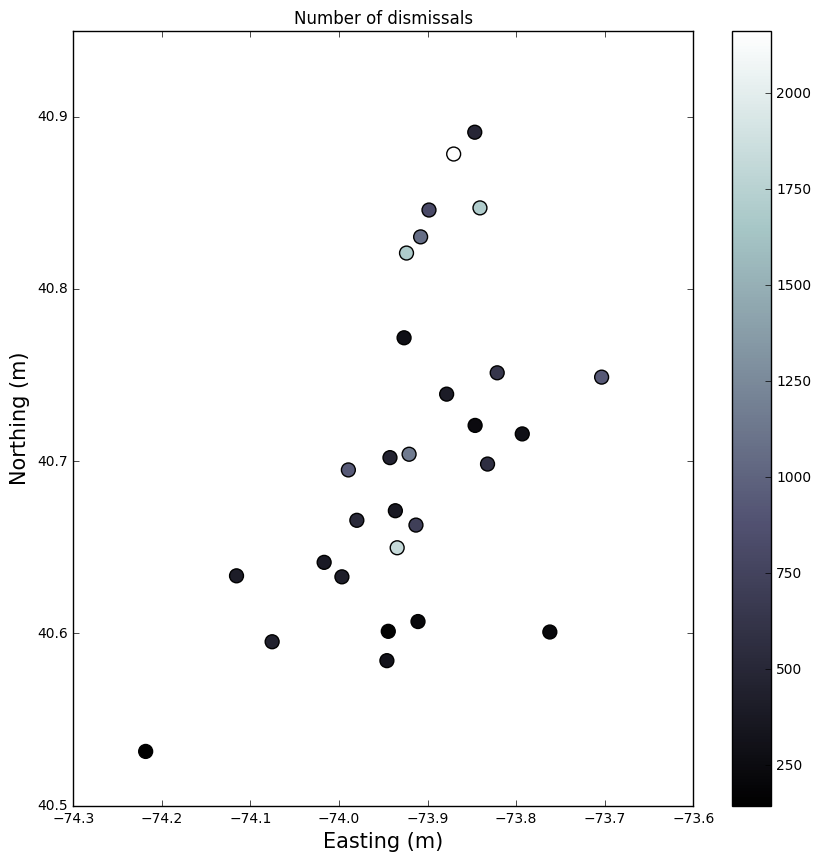

In [35]:
krigdata = np.zeros((len(asthma_zip_shp),3))

#code from Sebastian (sbg389)
# Loop through the dataframe and populate the x,y and count
for x in range(0, len(asthma_zip_shp)):
    krigdata[x][0] = asthma_zip_shp.centers[x].x
    krigdata[x][1] = asthma_zip_shp.centers[x].y
    krigdata[x][2] = asthma_zip_shp['count'][x]
    
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')   # (x, y, color=count)
pl.xlabel("Easting (m)", fontsize=15)
pl.ylabel("Northing (m)", fontsize=15)
pl.title('Number of dismissals') ;
pl.colorbar()